# Equal Variance Contribution Risk Parity Study

In [2]:
import numpy as np
import pandas as pd
import sklearn as skl
import backtest_tools.portfolio_tools as pt
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

Get Data

In [3]:
# Returns of opening prices
open_asset_returns = pd.DataFrame()

# Returns of close prices
close_asset_returns = pd.DataFrame()

tickers = ['GLD', 'SPY', 'TLT', 'VNQ']

for ticker in tickers:

    prices = yf.download(ticker, start='1970-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_rets = prices['Adj Close'].pct_change().dropna()
    close_rets = close_rets.rename(ticker)
    open_rets = prices['Open'].pct_change().dropna()
    open_rets = open_rets.rename(ticker)

    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
    open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Get covariance matrix
cov = close_asset_returns.cov()
cov

,GLD,SPY,TLT,VNQ
GLD,0.000126,0.000007,0.000016,0.000010
SPY,0.000007,0.000142,-0.000039,0.000176
TLT,0.000016,-0.000039,0.000082,-0.000035
VNQ,0.000010,0.000176,-0.000035,0.000355


In [69]:
# Randomize portfolio weights
w = pd.Series(np.random.random(size=(len(close_asset_returns.columns))), index=cov.index)
w = w / w.sum()
w

GLD    0.060909
SPY    0.386687
TLT    0.225970
VNQ    0.326434
dtype: float64

# Variance on an Intuitive Basis:
- = SUM(portfolio weight * risk associated with each position as it relates to to its relationship with other positions) * portfolio weight
- = <<w, covariance matrix>, w>


In [6]:
# Get total portfolio variance (daily)
var = w.T.dot(cov).dot(w)
var.round(5)

6e-05

# Risk-Contribution Intuition

In [9]:
# Get each w.dot(covariance) * w = weighted absolute risk associated with each position
weighted_absolute_risk = w.T.dot(cov) * w
weighted_absolute_risk

GLD    0.000006
SPY    0.000004
TLT    0.000008
VNQ    0.000044
dtype: float64

In [12]:
# Get proportional risk contributions = each position's % contribution to total risk
# risk_contribution = (weighted_absolute_risk) / weighted_absolute_risk.sum() --> Variance = SUM(weighted_absolute_risk)
risk_contribution = (weighted_absolute_risk) / var
risk_contribution

GLD    0.096243
SPY    0.071224
TLT    0.126900
VNQ    0.705633
dtype: float64

# Solve for Risk Parity

In [64]:
from scipy.optimize import minimize as opt

def risk_parity_obj(w: pd.Series, cov: pd.DataFrame):

    # N portfolio constituents
    n = len(w)

    # Get equal variance contribution weights
    equal_risk_contribution = np.array([1 / n] * n)

    # Get portfolio variance
    variance = w.T.dot(cov).dot(w)

    # Get weighted asbolute risk
    weighted_absolute_risk = w.T.dot(cov) * w

    # Get each constituent's proportion risk contribution
    risk_contribution = weighted_absolute_risk / variance

    # Measure the absolute difference between current vs. equal risk contribution
    diff = np.abs((risk_contribution - equal_risk_contribution)).sum()

    return diff 

n = len(w)

initial_guess = pd.Series(np.array([1/n] * n), index=cov.index)

constraints =   [# Portfolio weights sum to 100%
                {"type": "eq", "fun": lambda w: w.sum() - 1}
                ]

risk_parity_w = opt(risk_parity_obj, 
                            initial_guess, 
                            args=(cov), 
                            method='SLSQP',
                            constraints=constraints)['x']

risk_parity_w = pd.Series(risk_parity_w, index=cov.index)

risk_parity_w

GLD    0.238396
SPY    0.230636
TLT    0.403626
VNQ    0.127342
dtype: float64

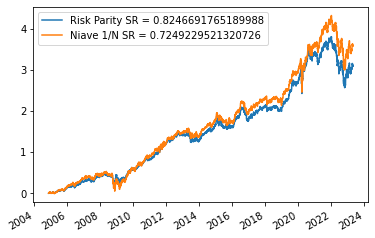

In [68]:
rp_rets = close_asset_returns.dot(risk_parity_w)
naive_rets = close_asset_returns.dot(initial_guess)
pt.cumulative_returns(rp_rets).plot(label=f"Risk Parity SR = {pt.sharpe_ratio(rp_rets)}")
pt.cumulative_returns(naive_rets).plot(label=f"Niave 1/N SR = {pt.sharpe_ratio(naive_rets)}")
plt.legend()

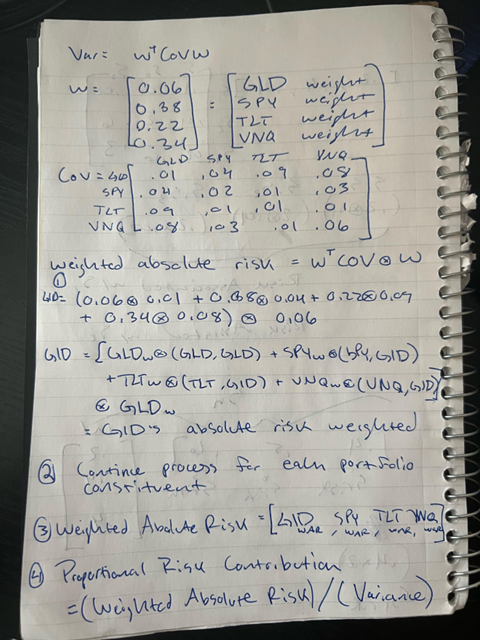

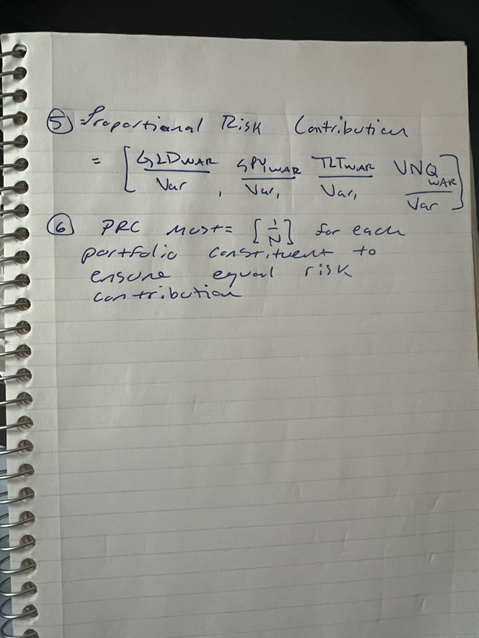